### Data Prep and EDA

In [549]:
#libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, HuberRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [570]:
# Load dataset
df = pd.read_excel("/Users/feepieper/Library/CloudStorage/OneDrive-Persönlich/Ironhack/Module4/projects/mini-project-dsai-ml-regression/data/regression_data.xls")
pd.set_option('display.max_columns', None) 
df.head()
df.columns

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'price'],
      dtype='object')

In [551]:
# cleaning (missing values, outliers)
df = df.dropna()

                 id                           date  bedrooms  bathrooms  \
count        21,597                          21597    21,597     21,597   
mean  4,580,474,288  2014-10-29 04:20:38.171968512         3          2   
min       1,000,102            2014-05-02 00:00:00         1          0   
25%   2,123,049,175            2014-07-22 00:00:00         3          2   
50%   3,904,930,410            2014-10-16 00:00:00         3          2   
75%   7,308,900,490            2015-02-17 00:00:00         4          2   
max   9,900,000,190            2015-05-27 00:00:00        33          8   
std   2,876,735,716                            NaN         1          1   

       sqft_living  sqft_lot  floors  waterfront   view  condition  grade  \
count       21,597    21,597  21,597      21,597 21,597     21,597 21,597   
mean         2,080    15,099       1           0      0          3      8   
min            370       520       1           0      0          1      3   
25%          1,4

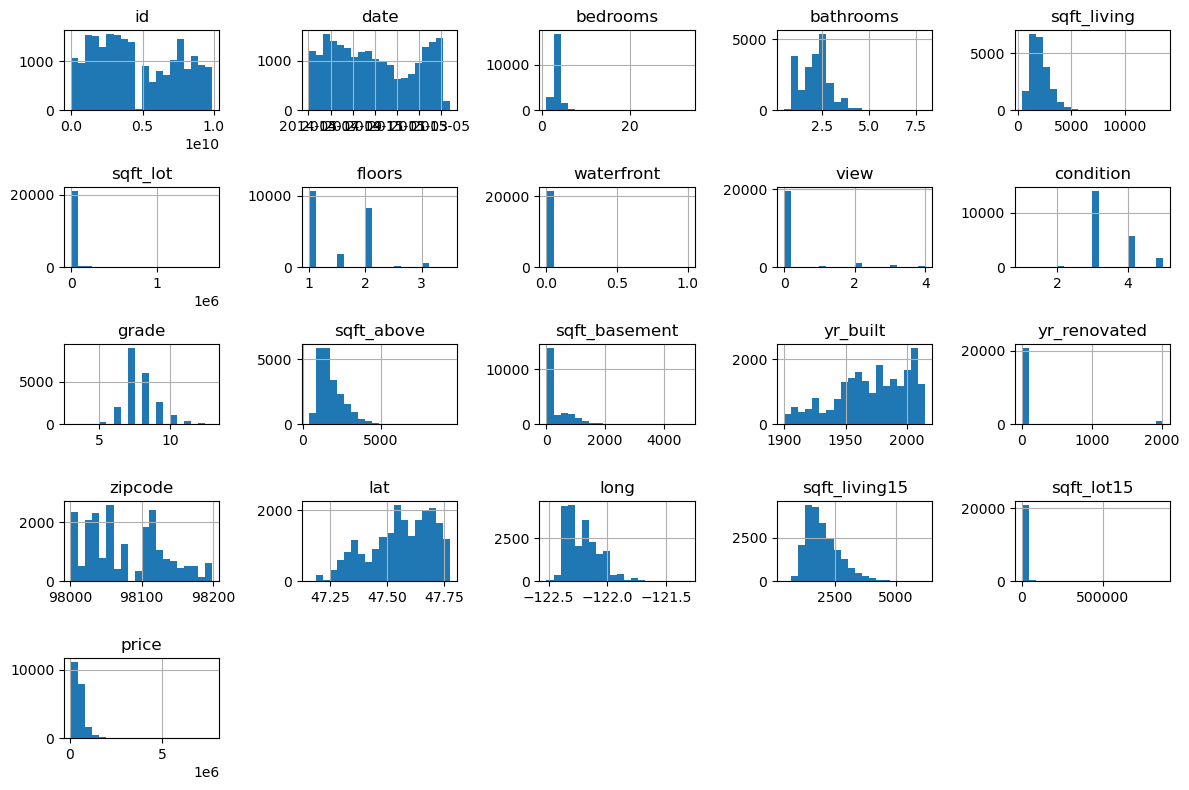

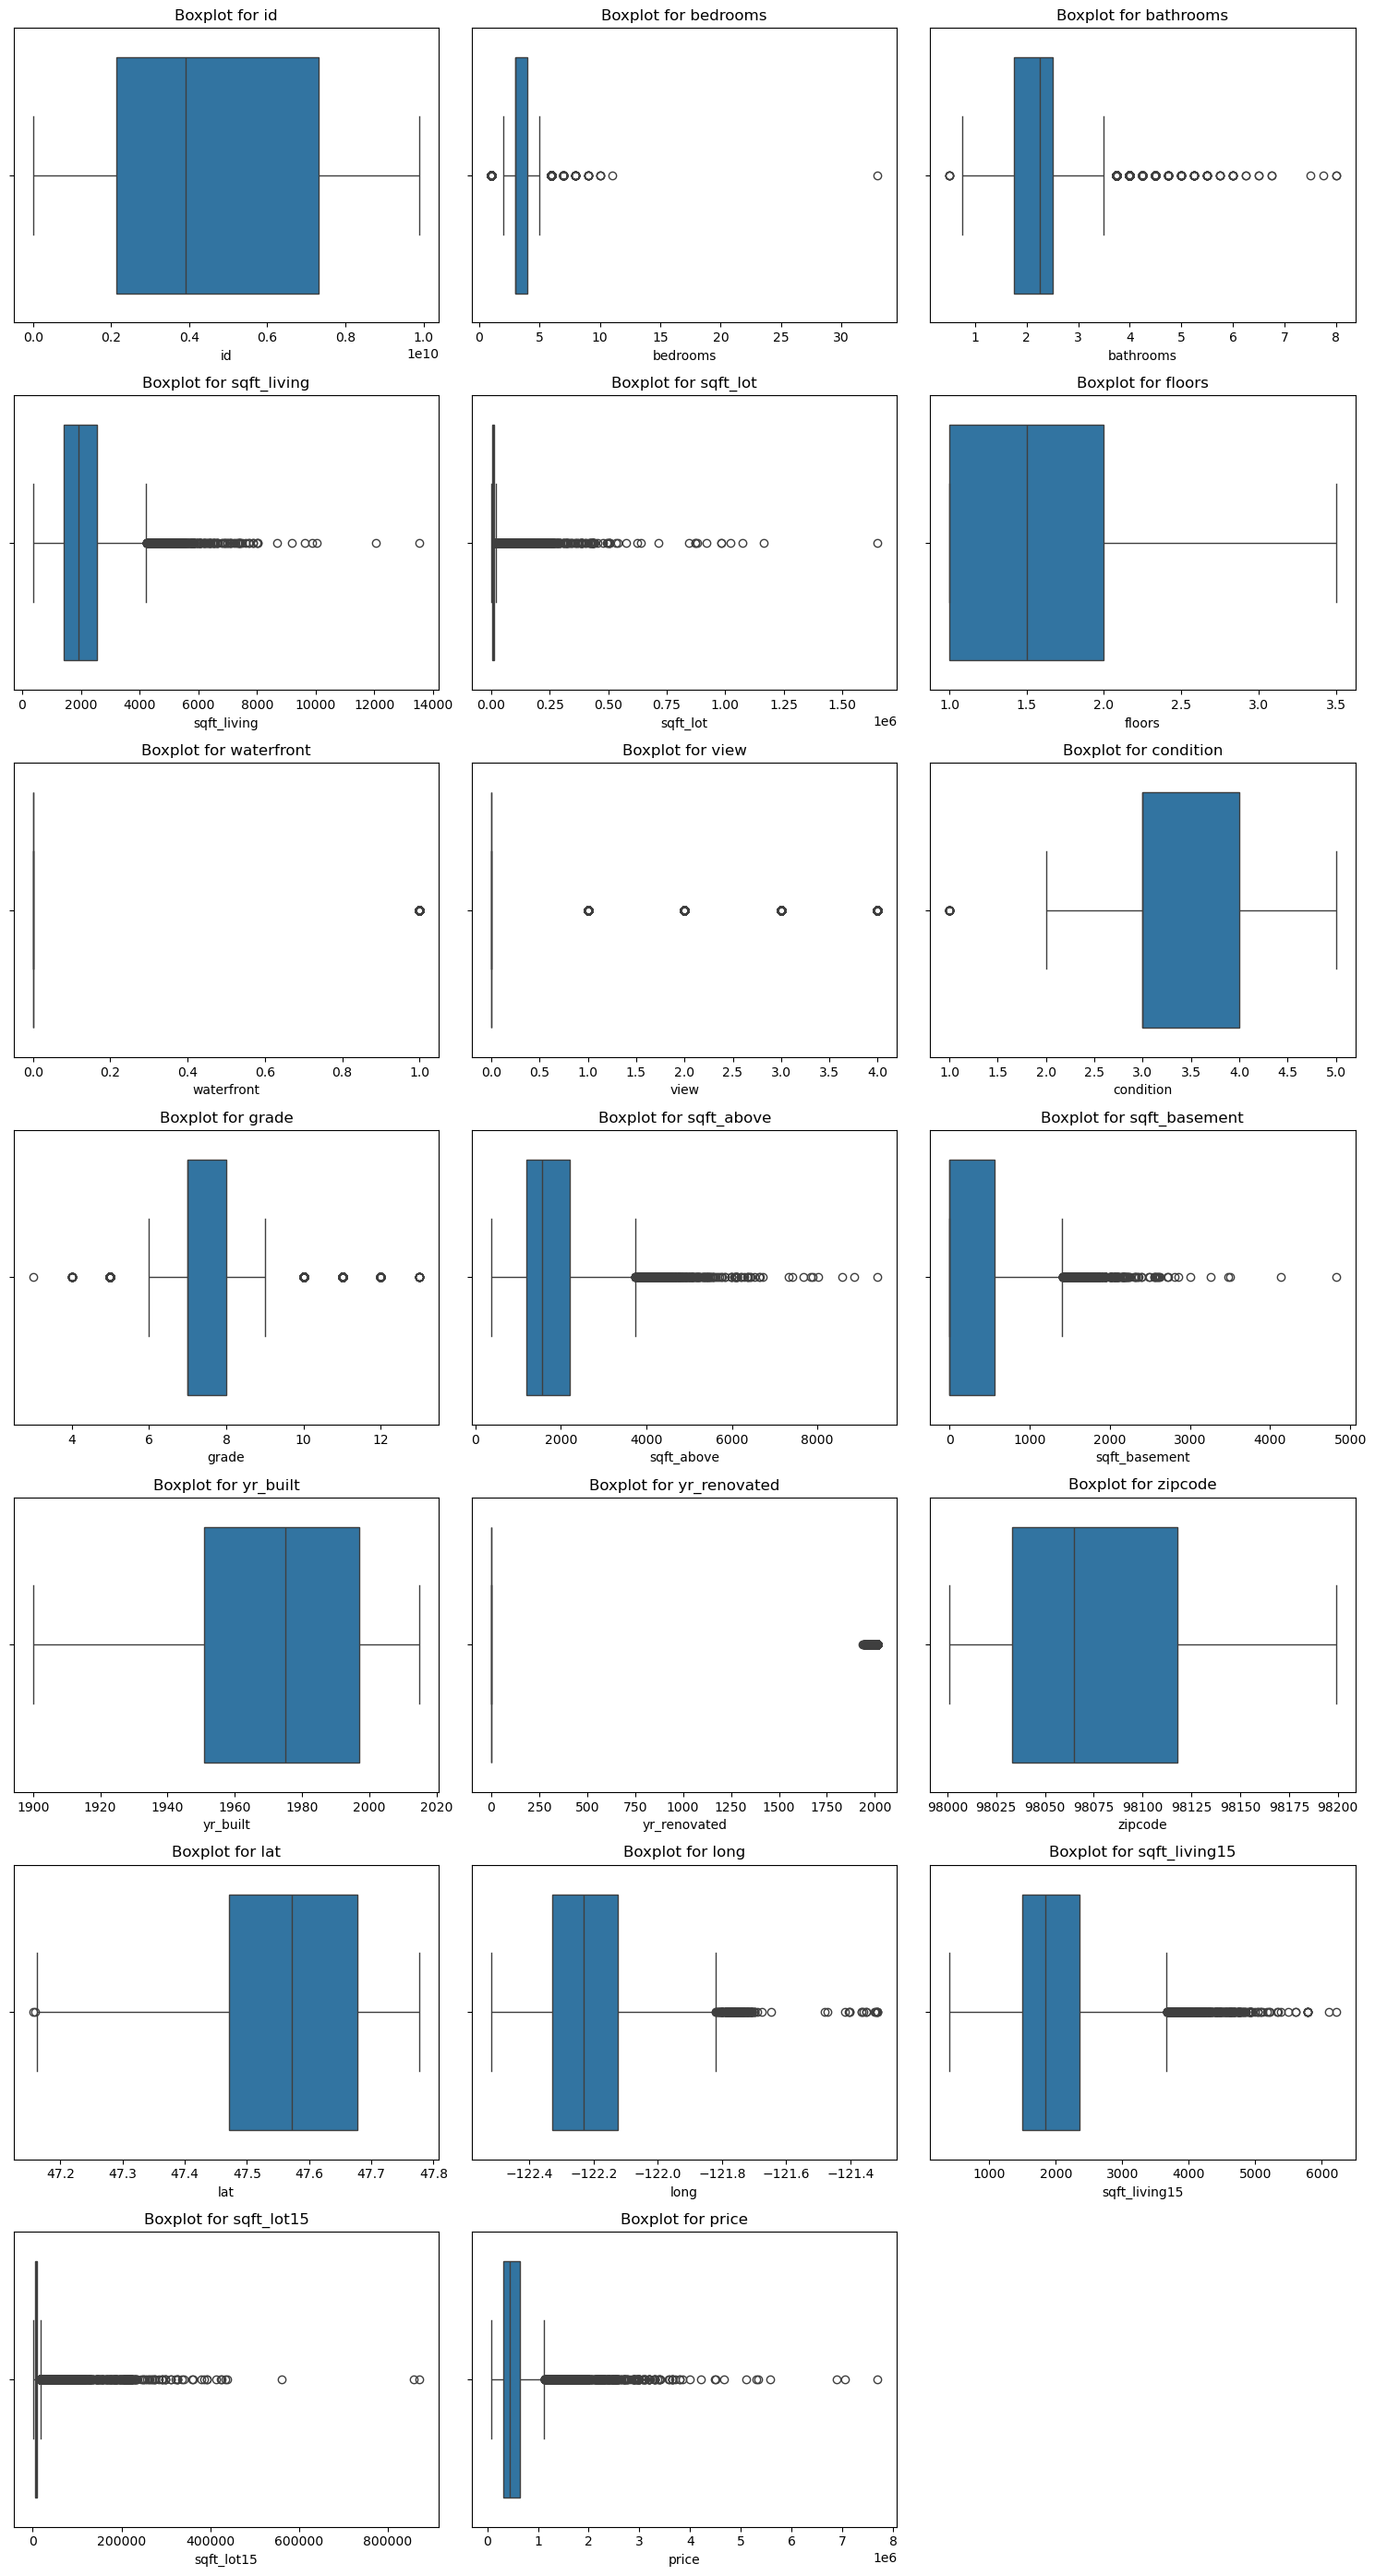

In [569]:
# -----------------------
# 1. First overview
# -----------------------
pd.set_option('display.float_format', '{:,.0f}'.format)
print(df.describe())             # Statistical summary for numerical columns
print(df.isnull().sum())         # Number of missing values per column

# -----------------------
# 2. Basic visualizations
# -----------------------
# Histogram for numerical columns
df.hist(bins=20, figsize=(12, 8))
plt.tight_layout()
plt.show()

# -----------------------
# 3. Numerical columns → Boxplots (all in one figure)
# -----------------------
numerical_columns = df.select_dtypes(include=['number']).columns
n_cols = 3  # number of plots per row
n_rows = (len(numerical_columns) + n_cols - 1) // n_cols  # ceil division

plt.figure(figsize=(5*n_cols, 4*n_rows))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot for {col}')
    plt.tight_layout()

plt.show()


# Feature preprocessing

In [553]:
# Drop columns that add no predictive value
df_removed = df.drop(columns=["id"])
df_removed.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,2014-10-13,3,1,1180,5650,1,0,0,3,7,1180,0,1955,0,98178,48,-122,1340,5650,221900
1,2014-12-09,3,2,2570,7242,2,0,0,3,7,2170,400,1951,1991,98125,48,-122,1690,7639,538000
2,2015-02-25,2,1,770,10000,1,0,0,3,6,770,0,1933,0,98028,48,-122,2720,8062,180000
3,2014-12-09,4,3,1960,5000,1,0,0,5,7,1050,910,1965,0,98136,48,-122,1360,5000,604000
4,2015-02-18,3,2,1680,8080,1,0,0,3,8,1680,0,1987,0,98074,48,-122,1800,7503,510000


In [554]:
# Adjust data types
# Zipcode as string
df_removed['zipcode'] = df_removed['zipcode'].astype(str)

# Waterfront as string for later dummy encoding
df_removed['waterfront'] = df_removed['waterfront'].astype(str)

df_removed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           21597 non-null  datetime64[ns]
 1   bedrooms       21597 non-null  int64         
 2   bathrooms      21597 non-null  float64       
 3   sqft_living    21597 non-null  int64         
 4   sqft_lot       21597 non-null  int64         
 5   floors         21597 non-null  float64       
 6   waterfront     21597 non-null  object        
 7   view           21597 non-null  int64         
 8   condition      21597 non-null  int64         
 9   grade          21597 non-null  int64         
 10  sqft_above     21597 non-null  int64         
 11  sqft_basement  21597 non-null  int64         
 12  yr_built       21597 non-null  int64         
 13  yr_renovated   21597 non-null  int64         
 14  zipcode        21597 non-null  object        
 15  lat            2159

In [555]:
# encode categorical variables

# Map zip codes to regions: City / Suburb / Other
def zip_to_region(zip_code):
    if zip_code.startswith('981'):
        return 'City'
    elif zip_code.startswith('980'):
        return 'Suburb'
    else:
        return 'Other'

df_removed['region'] = df_removed['zipcode'].apply(zip_to_region)

# Drop original zipcode column
df_removed = df_removed.drop(columns=["zipcode"])
df_removed[['waterfront', 'region']] = df_removed[['waterfront', 'region']].astype('category')

df_removed['region'].value_counts()


region
Suburb    12624
City       8973
Name: count, dtype: int64

# Feature Engineering

In [556]:
# House age
df_removed['date'] = pd.to_datetime(df_removed['date'])
df_removed['house_age'] = df_removed['date'].dt.year - df_removed['yr_built']

# Renovated: binary
df_removed['renovated'] = df_removed['yr_renovated'].apply(lambda x: 0 if x == 0 else 1)

# time to last renovation
df_removed["time_to_last_renovation"] = df_removed.apply(
    lambda row: row["date"].year - row["yr_renovated"] if row["yr_renovated"] != 0 else None,
    axis=1
)
df_removed['time_to_last_renovation'] = df_removed['time_to_last_renovation'].fillna(0)

# Living space per floor
df_removed['living_per_floor'] = df_removed['sqft_living'] / df_removed['floors']

# Ratio of living area to lot size
df_removed['living_lot_ratio'] = df_removed['sqft_living'] / df_removed['sqft_lot']

# Ratio of above-ground area to basement
df_removed['above_basement_ratio'] = df_removed.apply(
    lambda row: row['sqft_above'] / row['sqft_basement'] if row['sqft_basement'] != 0 else 0, axis=1
)

# Beds per bathroom
df_removed['bed_per_bath'] = df_removed.apply(
    lambda row: row['bedrooms'] / row['bathrooms'] if row['bathrooms'] != 0 else 0, axis=1
)

# Lot type: none / terrace / garden
def lot_type(sqft):
    if sqft == 0:
        return 'none'
    elif 1 <= sqft <= 20:
        return 'terrace'
    else:
        return 'garden'

df_removed['lot_type'] = df_removed['sqft_lot'].apply(lot_type)

# Basement presence: binary
df_removed['has_basement'] = df_removed['sqft_basement'].apply(lambda x: 0 if x == 0 else 1)


In [557]:
# drop old columns no longer needed
df_removed = df_removed.drop(columns=[
    "yr_built", "yr_renovated", "bathrooms", "sqft_lot", 
    "sqft_basement", "sqft_above", "sqft_living", "date"
])

df_removed.head()

,bedrooms,floors,waterfront,view,condition,grade,lat,long,sqft_living15,sqft_lot15,price,region,house_age,renovated,time_to_last_renovation,living_per_floor,living_lot_ratio,above_basement_ratio,bed_per_bath,lot_type,has_basement
0,3,1,0,0,3,7,48,-122,1340,5650,221900,City,59,0,0,"1,180",0,0,3,garden,0
1,3,2,0,0,3,7,48,-122,1690,7639,538000,City,63,1,23,"1,285",0,5,1,garden,1
2,2,1,0,0,3,6,48,-122,2720,8062,180000,Suburb,82,0,0,770,0,0,2,garden,0
3,4,1,0,0,5,7,48,-122,1360,5000,604000,City,49,0,0,"1,960",0,1,1,garden,1
4,3,1,0,0,3,8,48,-122,1800,7503,510000,Suburb,28,0,0,"1,680",0,0,2,garden,0


In [558]:
# create dummy variables
categorical_columns = ['condition', 'region', 'waterfront', 'renovated', 'lot_type', 'has_basement']
df_removed = pd.get_dummies(df_removed, columns=categorical_columns, prefix=categorical_columns)

df_removed.head()
df_removed.dtypes

bedrooms                     int64
floors                     float64
view                         int64
grade                        int64
lat                        float64
long                       float64
sqft_living15                int64
sqft_lot15                   int64
price                        int64
house_age                    int64
time_to_last_renovation    float64
living_per_floor           float64
living_lot_ratio           float64
above_basement_ratio       float64
bed_per_bath               float64
condition_1                   bool
condition_2                   bool
condition_3                   bool
condition_4                   bool
condition_5                   bool
region_City                   bool
region_Suburb                 bool
waterfront_0                  bool
waterfront_1                  bool
renovated_0                   bool
renovated_1                   bool
lot_type_garden               bool
has_basement_0                bool
has_basement_1      

In [559]:
# define features and targets
features = df_removed.drop(columns=["price"])
target = df_removed["price"]

features.head()

,bedrooms,floors,view,grade,lat,long,sqft_living15,sqft_lot15,house_age,time_to_last_renovation,living_per_floor,living_lot_ratio,above_basement_ratio,bed_per_bath,condition_1,condition_2,condition_3,condition_4,condition_5,region_City,region_Suburb,waterfront_0,waterfront_1,renovated_0,renovated_1,lot_type_garden,has_basement_0,has_basement_1
0,3,1,0,7,48,-122,1340,5650,59,0,"1,180",0,0,3,False,False,True,False,False,True,False,True,False,True,False,True,True,False
1,3,2,0,7,48,-122,1690,7639,63,23,"1,285",0,5,1,False,False,True,False,False,True,False,True,False,False,True,True,False,True
2,2,1,0,6,48,-122,2720,8062,82,0,770,0,0,2,False,False,True,False,False,False,True,True,False,True,False,True,True,False
3,4,1,0,7,48,-122,1360,5000,49,0,"1,960",0,1,1,False,False,False,False,True,True,False,True,False,True,False,True,False,True
4,3,1,0,8,48,-122,1800,7503,28,0,"1,680",0,0,2,False,False,True,False,False,False,True,True,False,True,False,True,True,False


# Modeling & Evaluation Phase

In [560]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Validation Split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=3)


In [561]:
# Linear Model: Linear Regression Model
# risk! outliers 
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),       
    ('regressor', LinearRegression())   
])

pipeline_lr.fit(X_train, y_train)
y_pred_lm = pipeline_lr.predict(X_val)

# Mean Squared Error (MSE) – mittlerer quadratischer Fehler
mse_lm = mean_squared_error(y_val, y_pred_lm)
print(f"MSE: {mse_lm}")

# Root Mean Squared Error (RMSE) – Wurzel des MSE, gleiche Einheit wie Ziel
rmse_lm = mean_squared_error(y_val, y_pred_lm, squared=False)
print(f"RMSE: {rmse_lm}")

# Mean Absolute Error (MAE) – mittlerer absoluter Fehler
mae_lm = mean_absolute_error(y_val, y_pred_lm)
print(f"MAE: {mae_lm}")

# R²-Score 
r2_lm = r2_score(y_val, y_pred_lm)
print(f"R²: {r2_lm}")

MSE: 39885138411.53194
RMSE: 199712.63958881504
MAE: 130640.03019709002
R²: 0.6752943911066909


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [562]:
# Ensemble Model & Decision Tree: RandomForest (Bagging)
# robust to outliers
# GridSearchCV
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),       
    ('regressor', RandomForestRegressor())   
])

param_grid_rf = {
    'regressor__n_estimators': [300, 350, 400],   
    'regressor__max_depth': [450, 500, 550]     
}

# GridSearchCV Setup
grid_search_rf = GridSearchCV(
    estimator=pipeline_rf,
    param_grid=param_grid_rf,
    cv=5,
    scoring='r2',   
    n_jobs=-1
)

# Training
grid_search_rf.fit(X_train, y_train)

# Best Modell und Score
print(f"Best parameters: {grid_search_rf.best_params_}")
print(f"Best CV score: {grid_search_rf.best_score_}")

# Predictions on Validation Set
y_pred_rf = grid_search_rf.predict(X_val)

# Mean Squared Error (MSE) 
mse_rf = mean_squared_error(y_val, y_pred_rf)
print(f"MSE: {mse_rf}")

# Root Mean Squared Error (RMSE) 
rmse_rf = mean_squared_error(y_val, y_pred_rf, squared=False)
print(f"RMSE: {rmse_rf}")

# Mean Absolute Error (MAE)
mae_rf = mean_absolute_error(y_val, y_pred_rf)
print(f"MAE: {mae_rf}")

# R²-Score 
r2_rf = r2_score(y_val, y_pred_rf)
print(f"R²: {r2_rf}")

Best parameters: {'regressor__max_depth': 500, 'regressor__n_estimators': 300}
Best CV score: 0.8575815328678669
MSE: 16546581745.820055
RMSE: 128633.51719447017
MAE: 73746.35265107657
R²: 0.8652939888174992


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [563]:
# Ensemble Model: GradientBoosting (Boosting)
# use paramter tuning to handle outliers
# GridSearchCV
pipeline_GB = Pipeline([
    ('scaler', StandardScaler()),       
    ('regressor', GradientBoostingRegressor())   
])

param_grid_GB = {
    'regressor__n_estimators': [100, 300, 500],
    'regressor__learning_rate': [0.01, 0.1],
    'regressor__max_depth': [3, 5, 7]  
}

# GridSearchCV Setup
grid_search_GB = GridSearchCV(
    estimator=pipeline_GB,
    param_grid=param_grid_GB,
    cv=5,
    scoring='r2',   
    n_jobs=-1
)

# Training
grid_search_GB.fit(X_train, y_train)

# Best Modell und Score
print(f"Best parameters: {grid_search_GB.best_params_}")
print(f"Best CV score: {grid_search_GB.best_score_}")

# Predictions on Validation Set
y_pred_GB = grid_search_GB.predict(X_val)

# Mean Squared Error (MSE) 
mse_GB = mean_squared_error(y_val, y_pred_GB)
print(f"MSE: {mse_rf}")

# Root Mean Squared Error (RMSE) 
rmse_GB = mean_squared_error(y_val, y_pred_GB, squared=False)
print(f"RMSE: {rmse_GB}")

# Mean Absolute Error (MAE)
mae_GB = mean_absolute_error(y_val, y_pred_GB)
print(f"MAE: {mae_GB}")

# R²-Score 
r2_GB = r2_score(y_val, y_pred_GB)
print(f"R²: {r2_GB}")

Best parameters: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__n_estimators': 500}
Best CV score: 0.8784344046541179
MSE: 16546581745.820055
RMSE: 119992.89906349248
MAE: 69306.2193961693
R²: 0.8827832220397743


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [564]:
# KNN 
# use parameter tuning to handle outliers
# GridSearchCV
pipeline_KNN = Pipeline([
    ('scaler', StandardScaler()),       
    ('regressor', KNeighborsRegressor())   
])

param_grid_KNN = {
    'regressor__n_neighbors': [6, 7, 8],   
}

# GridSearchCV Setup
grid_search_KNN = GridSearchCV(
    estimator=pipeline_KNN,
    param_grid=param_grid_KNN,
    cv=5,
    scoring='r2',   
    n_jobs=-1
)

# Training
grid_search_KNN.fit(X_train, y_train)

# Best Modell und Score
print(f"Best parameters: {grid_search_KNN.best_params_}")
print(f"Best CV score: {grid_search_KNN.best_score_}")

# Predictions on Validation Set
y_pred_KNN = grid_search_KNN.predict(X_val)

# Mean Squared Error (MSE) 
mse_KNN = mean_squared_error(y_val, y_pred_KNN)
print(f"MSE: {mse_KNN}")

# Root Mean Squared Error (RMSE) 
rmse_KNN = mean_squared_error(y_val, y_pred_KNN, squared=False)
print(f"RMSE: {rmse_KNN}")

# Mean Absolute Error (MAE)
mae_KNN = mean_absolute_error(y_val, y_pred_KNN)
print(f"MAE: {mae_KNN}")

# R²-Score 
r2_KNN = r2_score(y_val, y_pred_KNN)
print(f"R²: {r2_KNN}")

Best parameters: {'regressor__n_neighbors': 6}
Best CV score: 0.737117841036089
MSE: 29036094959.209507
RMSE: 170399.80915250318
MAE: 95730.2742669753
R²: 0.7636166434641704


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [565]:
# Lasso Pipeline
pipeline_lasso = Pipeline([
    ('scaler', StandardScaler()),       
    ('regressor', Lasso())   
])

# Parameter grid for GridSearch
param_grid_lasso = {
    'regressor__alpha': [0.01, 0.1, 1, 10, 100]  # Regularization parameter
}

# GridSearchCV setup
grid_search_lasso = GridSearchCV(
    estimator=pipeline_lasso,
    param_grid=param_grid_lasso,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

# Training
grid_search_lasso.fit(X_train, y_train)

# Best model and score
print(f"Best parameters: {grid_search_lasso.best_params_}")
print(f"Best CV score: {grid_search_lasso.best_score_}")

# Predictions on validation set
y_pred_lasso = grid_search_lasso.predict(X_val)

# Mean Squared Error (MSE) 
mse_lasso = mean_squared_error(y_val, y_pred_lasso)
print(f"MSE: {mse_lasso}")

# Root Mean Squared Error (RMSE) 
rmse_lasso = mean_squared_error(y_val, y_pred_lasso, squared=False)
print(f"RMSE: {rmse_lasso}")

# Mean Absolute Error (MAE)
mae_lasso = mean_absolute_error(y_val, y_pred_lasso)
print(f"MAE: {mae_lasso}")

# R² score
r2_lasso = r2_score(y_val, y_pred_lasso)
print(f"R²: {r2_lasso}")

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.705e+12, tolerance: 1.487e+11
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.705e+12, tolerance: 1.487e+11
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.706e+12, toler

Best parameters: {'regressor__alpha': 100}
Best CV score: 0.6644317015844148
MSE: 39831747726.66835
RMSE: 199578.92605851038
MAE: 130308.66777119617
R²: 0.675729045605291


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [581]:
pd.set_option('display.float_format', '{:.3f}'.format)

results = {
    'Model': ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'KNN', 'Lasso'],
    'MSE': [round(mse_lm), round(mse_rf), round(mse_GB), round(mse_KNN), round(mse_lasso)],
    'RMSE': [round(rmse_lm), round(rmse_rf), round(rmse_GB), round(rmse_KNN), round(rmse_lasso)],
    'MAE': [round(mae_lm), round(mae_rf), round(mae_GB), round(mae_KNN), round(mae_lasso)],
    'R²': [round(r2_lm, 3), round(r2_rf, 3), round(r2_GB, 3), round(r2_KNN, 3), round(r2_lasso, 3)],
}

results_df = pd.DataFrame(results)
print(results_df)

               Model          MSE    RMSE     MAE    R²
0  Linear Regression  39885138412  199713  130640 0.675
1      Random Forest  16546581746  128634   73746 0.865
2  Gradient Boosting  14398295826  119993   69306 0.883
3                KNN  29036094959  170400   95730 0.764
4              Lasso  39831747727  199579  130309 0.676
